Small Medium Big -> Size Factor를 구해보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats

In [2]:
mktcap = pd.read_pickle("mktcap_without_stable.pickle").drop("RISE2", axis=1)
price  = pd.read_pickle("price_without_stable.pickle").drop("RISE2", axis=1)

In [3]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총, pct의 weekly를 구해줌
weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
mktcap_weekly = mktcap.resample("W").first()
weight_weekly = weight_daily.resample("W").first()

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
daily_rtn = sign_daily * pct
weekly_rtn = sign_weekly * pct_weekly

In [4]:
# mktcap 가중평균한 weekly returns
mkt_rtn = ((weekly_rtn * weight_weekly.shift(1)).sum(axis=1))

In [5]:
s = (weekly_rtn).loc[["2021-12-12"]]
idx = np.nanargmax(s)

# 문제가 되는 코인 -> 이게 리턴이 말이 되나??? (RISE2 드랍하면 좀 괜찮음)
s.iloc[:, idx]

2021-12-12    1.65423
Name: LBTC, dtype: float64

5개의 그룹(모멘텀 기준)

In [6]:
thresh = mktcap_weekly.apply(lambda x: np.nanpercentile(x, [33, 66]), axis=1)
t1 = thresh.apply(lambda x: x[0])
t2 = thresh.apply(lambda x: x[1])

# masking에 사용하면 된다 (1 or NaN) 값을 담고 있음
small = mktcap_weekly.apply(lambda x: x <= t1, axis=0) \
                  .replace(True, 1).replace(False, np.nan)
medium = mktcap_weekly.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
high = mktcap_weekly.apply(lambda x: (t2 < x), axis=0) \
                  .replace(True, 1).replace(False, np.nan)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [7]:
# 그룹별 weights를 구하기
weight_s = (small * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_m = (medium * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_h = (high * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)

In [8]:
# 분위수 별로 들어가 있는 코인 수를 확인하자
pd.set_option("display.max_rows", 50)

num_coin = pd.concat([small.sum(1), medium.sum(1), high.sum(1)], axis=1)

# 횡단면 코인 개수가 그룹별로 20개는 넘는 날짜를 출력하자
slice = num_coin[num_coin > 18].dropna(axis=0)
start_date = slice.index[0]
print(start_date)
slice

2016-10-02 00:00:00


,0,1,2
2016-10-02,20.0,19.0,20.0
2017-02-19,20.0,19.0,20.0
2017-02-26,20.0,19.0,20.0
2017-03-05,20.0,20.0,21.0
2017-03-12,21.0,20.0,21.0
...,...,...,...
2023-02-12,436.0,436.0,449.0
2023-02-19,438.0,438.0,451.0
2023-02-26,442.0,441.0,455.0
2023-03-05,441.0,440.0,454.0


In [9]:
rtn_small = ((weekly_rtn * weight_s.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn_medium = ((weekly_rtn * weight_m.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn_high = ((weekly_rtn * weight_h.shift(1)).loc[start_date:].iloc[:-1].sum(1))

mkt_sample = mkt_rtn.loc[start_date:].iloc[:-1]

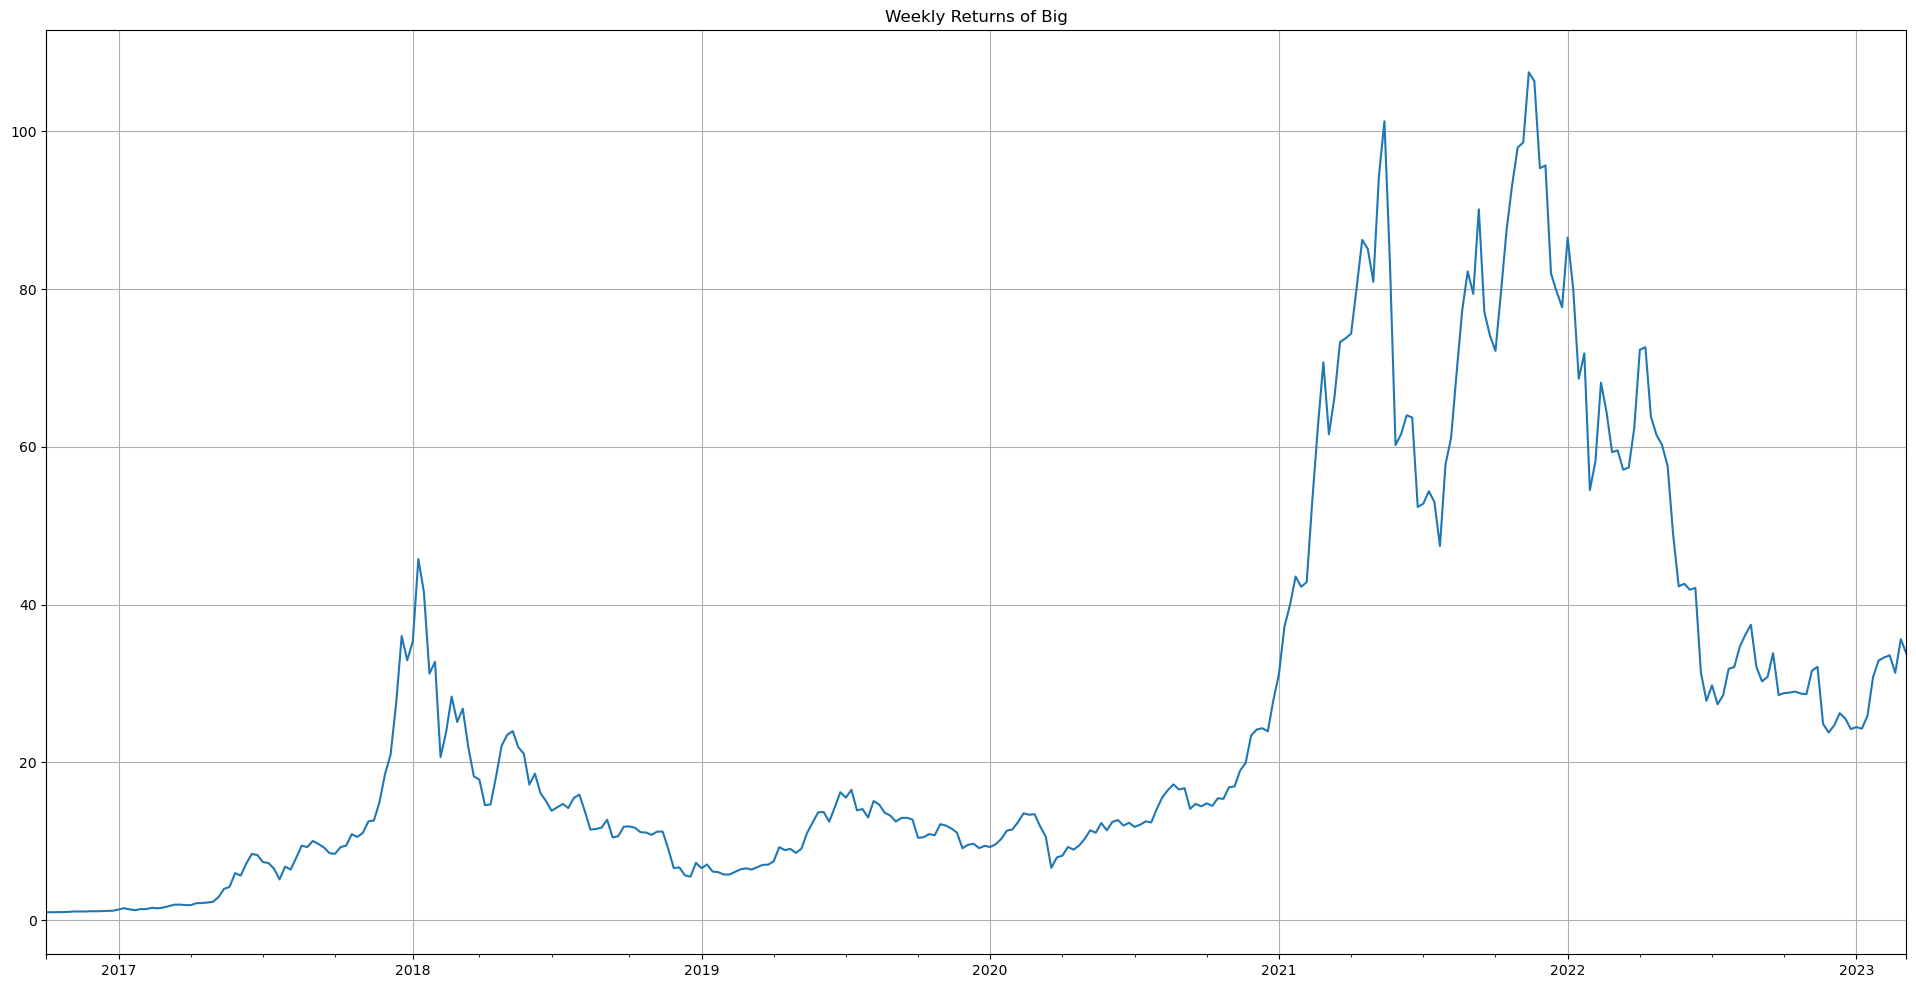

In [17]:
(rtn_high + 1).cumprod().plot(figsize=(24,12))
plt.grid()
plt.title("Weekly Returns of Big");

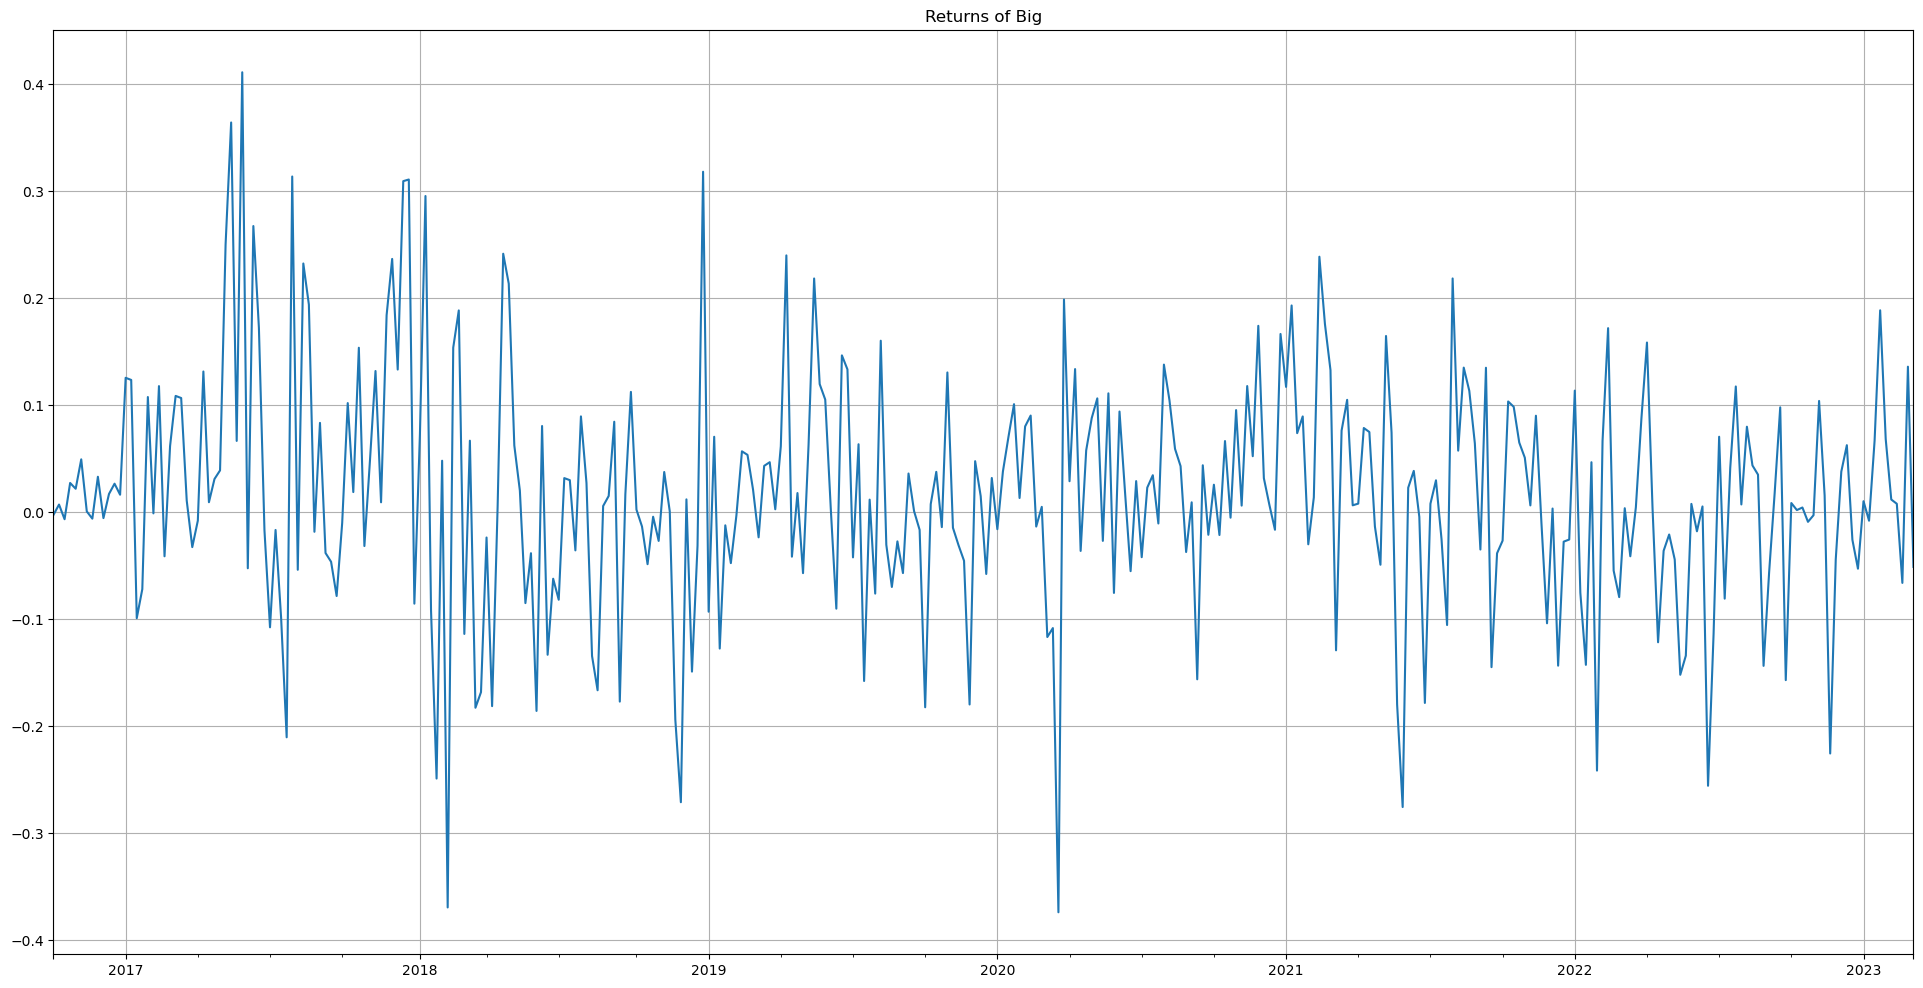

In [42]:
rtn_high.plot(figsize=(24,12))
plt.title("Returns of Big")
plt.grid();

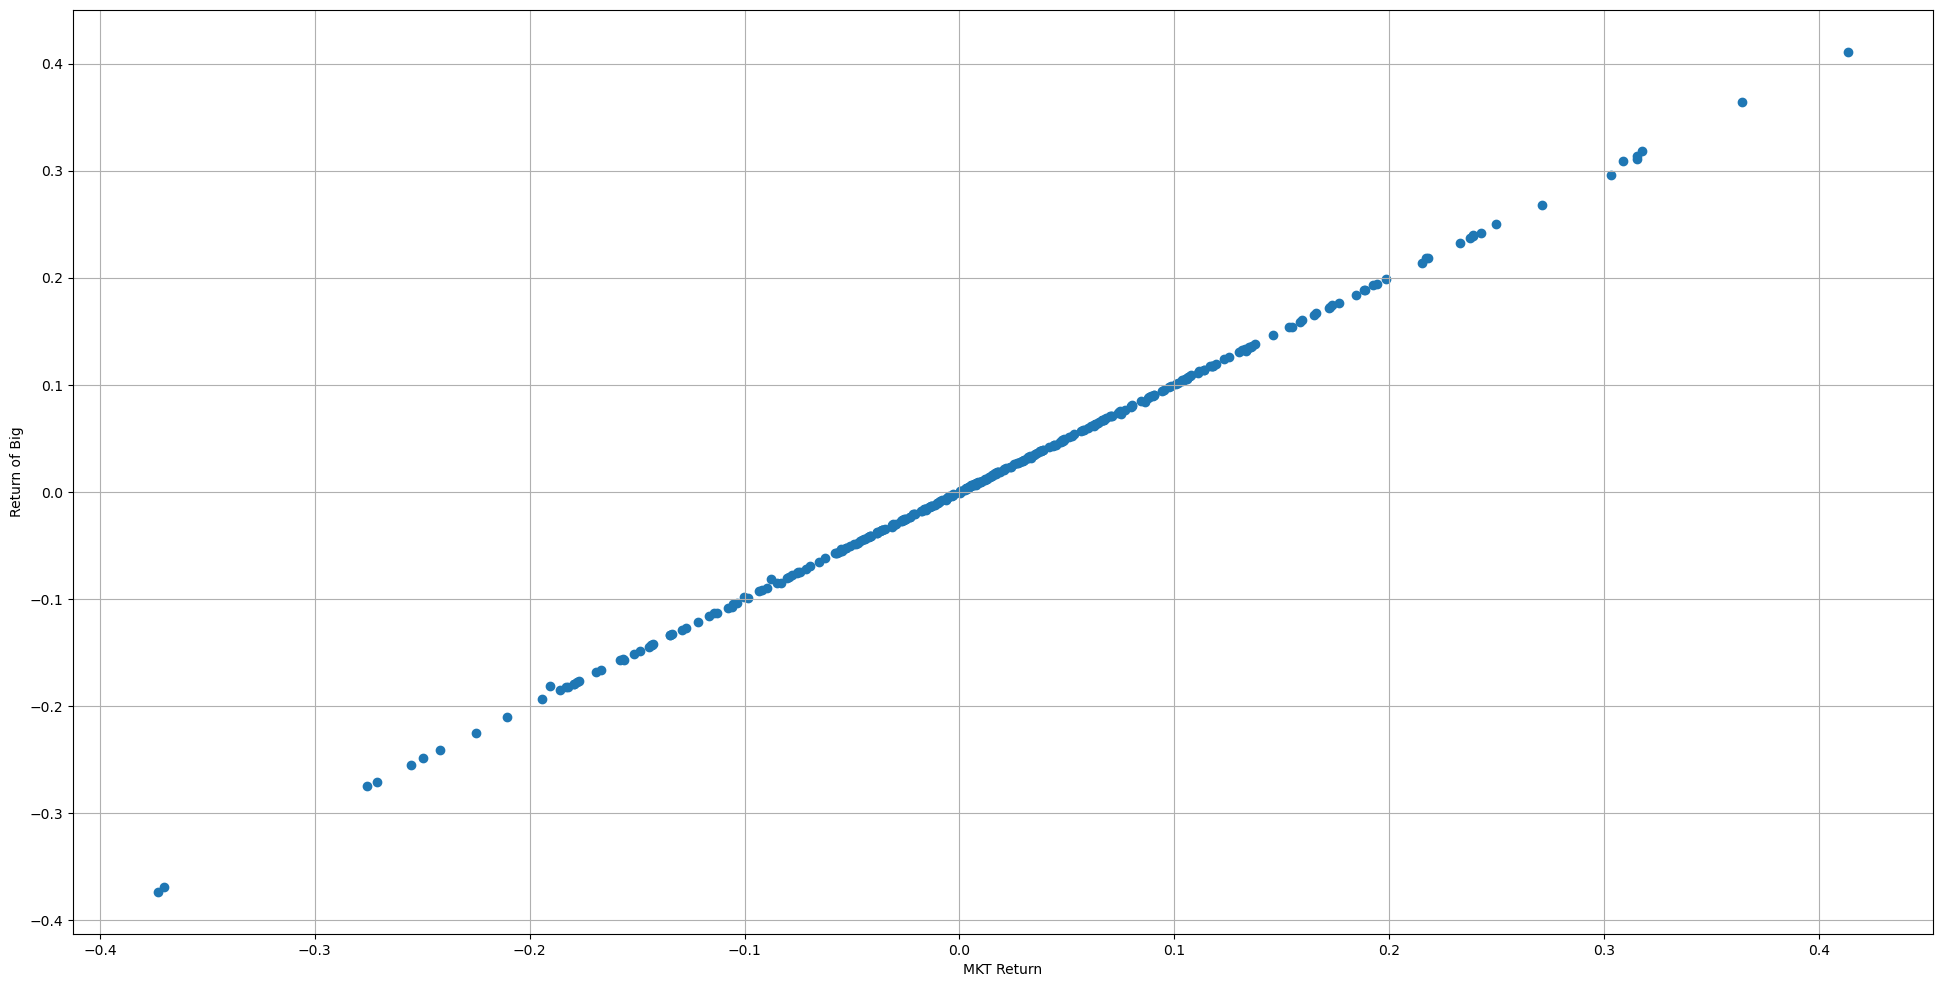

In [39]:
plt.figure(figsize=(24,12))
plt.scatter(mkt_sample,
            rtn_high)
plt.xlabel("MKT Return")
plt.ylabel("Return of Big")
plt.grid();

In [20]:
model = OLS(rtn_high, 
            add_constant(mkt_sample))

model.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     1.000     
Dependent Variable: y                AIC:                -3713.0654
Date:               2023-03-17 10:02 BIC:                -3705.4312
No. Observations:   336              Log-Likelihood:     1858.5    
Df Model:           1                F-statistic:        4.525e+06 
Df Residuals:       334              Prob (F-statistic): 0.00      
R-squared:          1.000            Scale:              9.2396e-07
---------------------------------------------------------------------
            Coef.    Std.Err.       t       P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const       0.0000     0.0001      0.1121   0.9108   -0.0001   0.0001
0           0.9977     0.0005   2127.2011   0.0000    0.9967   0.9986
-------------------------------------------------------------------
Omnibus:              215.386      Durbin-Watson:         1.736    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      19376.062
Skew:                 1.750        Prob(JB):              0.000    
Kurtosis:             40.037       Condition No.:         9        
===================================================================

"""

In [30]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_rtn.mean(), mkt_rtn.std())
print("Coin MKT Sample Period:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("Small:", rtn_small.mean().round(4), rtn_small.std(ddof=1))
print("Medium:", rtn_medium.mean().round(4), rtn_medium.std(ddof=1))
print("Big:", rtn_high.mean().round(4), rtn_high.std(ddof=1))

t, p_val = stats.ttest_ind(rtn_medium, rtn_high, equal_var=False)
t, p_val

Coin MKT: 0.015975700367382883 0.11248371663009019
Coin MKT Sample Period: 0.016820164040980988 0.11197631232808257
Small: 0.0412 0.1444976451052304
Medium: 0.021 0.14416905074110106
Big: 0.0168 0.11171918962072783


C:\Users\user\AppData\Local\Temp\ipykernel_9580\3011833931.py:12: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p_val = stats.ttest_ind(rtn_medium, rtn_high, equal_var=False)


(0.4268101639296381, 0.6696632530310913)

In [31]:
def calculate_cagr(df):
    holding_year = (len(df) / 52)
    cum = (df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr

In [32]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn_small)
calculate_cagr(rtn_medium)
calculate_cagr(rtn_high)

Market Return
The CAGR is 72.56%
----------------
Group Return
The CAGR is 437.74%
The CAGR is 82.62%
The CAGR is 72.50%


0.724970228082473

In [33]:
concat_df = pd.concat([rtn_small, rtn_medium, rtn_high, mkt_sample], axis=1)
concat_df.columns = ["Small","Medium","High","MKT"]

concat_df.corr()

,Small,Medium,High,MKT
Small,1.000000,0.896379,0.748667,0.752046
Medium,0.896379,1.000000,0.829822,0.833238
High,0.748667,0.829822,1.000000,0.999963
MKT,0.752046,0.833238,0.999963,1.000000
